In [1]:
import random
from collections import Counter

import numpy as np
import torch
from torch.distributions.categorical import Categorical
from torch.distributions.dirichlet import Dirichlet
from torch.distributions.log_normal import LogNormal
from torch.distributions.multivariate_normal import MultivariateNormal

from tqdm import trange
import matplotlib.pyplot as plt

### Set hyper parameters $\sigma^2_q, K, d$.

In [2]:
# hyper-parameters
sigma_q = 0.5
K = 3
d = 2

In [3]:
# read data
data_file = "./X.txt"
xs = []

with open(data_file, "r") as f:
    for line in f:
        x_i = line.split()
        x_i = [float(x) for x in x_i]
        xs.append(x_i)


xs = torch.tensor(xs, dtype=torch.float)

In [4]:
pi_prior_dist = Dirichlet(torch.tensor([1.0 for _ in range(K)]))
u_prior_dist = MultivariateNormal(torch.zeros(d), 5.0 * torch.eye(d))
lambda_prior_dist = LogNormal(0.1, 0.1)
v_prior_dist = MultivariateNormal(torch.zeros(d), 0.25 * torch.eye(d))

### Random initialization of $\theta$ by sampling it from prior distribution $p(\theta)$

In [5]:
pi = torch.tensor([1/K for _ in range(K)])
us = [u_prior_dist.sample() for _ in range(K)]
lambdas = [lambda_prior_dist.sample() for _ in range(K)]
vs = [v_prior_dist.sample() for _ in range(K)]

### Random cluster assignment $z_i$ for $i = 1, \ldots, n$


In [6]:
m = Categorical(pi)
zs = [m.sample() for _ in range(xs.size(0))]
zs = torch.tensor(zs, dtype=torch.long)


Gibbs-Sampling $z_i \sim \text{Cat}(\alpha_1, \ldots, \alpha_K)$  where $\alpha_k = \frac{\pi_k \mathcal{N}(x_i|\mu_k \lambda_k I_d + v_k v_k^T)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_i|\mu_j, \lambda_j I_d + v_j v_j^T)}$ 

Gibbs-Sampling $\pi \sim \text{Dir}(\pi; n_1 +1, \ldots, n_K +1)$

MCMC sampling (Metroplois-Hastings algorithm) $\phi'_k :=(\mu'_k, \lambda'_k, v'_k)$ with proposal distribution $\phi'_k \sim \mathcal{N}(\mu'_k;\mu_k, \sigma^2_q I_d) \log \mathcal{N}(\lambda'_k;\log \lambda_k, \sigma^2 I_d)\mathcal{N}(v'_k;v_k, \sigma^2_q I_d)$

Acceptance probability is $A(\phi'_k | \phi_k) =\min \Bigg\{1, \frac{p(X,Z,\theta \setminus \phi_k|\phi'_k)p(\phi'_k) \:q(u_k, \lambda_k, v_k|u'_k,\lambda'_k, v'_k)}{p(X,Z,\theta \setminus \phi_k)p(\phi_k)\:q(u'_k, \lambda'_k, v'_k| u_k, \lambda_k, v_k)} \Bigg\}$

In [7]:
num_iters = 300
joint_lls = []
t = trange(num_iters)
for epoch in t:
    for i in range(xs.size(0)):
        x_i = xs[i]
        numerators = []
        denom = 0.0
        for k in range(K):
            cov = lambdas[k] * torch.eye(d) + torch.ger(vs[k], vs[k])

            m = MultivariateNormal(us[k], cov)
            num = pi[k] * m.log_prob(x_i).exp()
            numerators.append(num)
            denom += num
        alphas = torch.tensor(numerators, dtype=torch.float) / denom

        # sample z ~ p(z_i|Z\{z_i},X,\theta)
        z_cat = Categorical(alphas)
        # update Z
        zs[i] = z_cat.sample()

    # sample \pi_k ~ p(\pi|X,Z,\theta \{z})
    concentrations = torch.ones(K).float()
    counter = Counter(zs.tolist())
    ns = torch.zeros_like(concentrations)

    for k, n_k in counter.items():
        ns[k] = n_k
    concentrations = concentrations + ns
    pi_dir = Dirichlet(concentrations)
    # update new \pi
    pi = pi_dir.sample()

    identity = torch.eye(d)

    for k in range(K):
        q_u_prime_dist = MultivariateNormal(us[k], sigma_q**2 * identity)
        q_lambda_prime_dist = LogNormal(torch.log(lambdas[k]), sigma_q**2)
        q_v_prime_dist = MultivariateNormal(vs[k], sigma_q**2 * identity)

        u_prime = q_u_prime_dist.sample()
        lambda_prime = q_lambda_prime_dist.sample()
        v_prime = q_v_prime_dist.sample()

        q_u_dist = MultivariateNormal(u_prime, sigma_q**2 * identity)
        q_lambda_dist = LogNormal(torch.log(lambda_prime), sigma_q**2)
        q_v_dist = MultivariateNormal(v_prime, sigma_q**2 * identity)

        q_num = torch.exp(q_u_dist.log_prob(us[k])
                          + q_lambda_dist.log_prob(lambdas[k])
                          + q_v_dist.log_prob(vs[k]))

        q_denom = torch.exp(q_u_prime_dist.log_prob(u_prime)
                            + q_lambda_prime_dist.log_prob(lambda_prime)
                            + q_v_prime_dist.log_prob(v_prime))

        q_ratio = q_num / q_denom

        p_theta = 1.0
        p_theta_prime = 1.0
        x_z_ll = 1.0
        x_z_prime_ll = 1.0

        # select x of which z = k
        boolean_mask = (zs == k)
        xs_k = xs[boolean_mask]
        cov = lambdas[k] * torch.eye(d) + torch.ger(vs[k], vs[k])
        x_normal = MultivariateNormal(us[k], cov)

        cov_prime = lambda_prime * torch.eye(d) + torch.ger(v_prime, v_prime)
        x_prime_normal = MultivariateNormal(u_prime, cov_prime)

        ll_ratio = torch.exp(x_prime_normal.log_prob(xs_k).sum()
                             - x_normal.log_prob(xs_k).sum())

        prior_ratio = torch.exp(u_prior_dist.log_prob(u_prime)
                                + lambda_prior_dist.log_prob(lambda_prime)
                                + v_prior_dist.log_prob(v_prime)
                                - u_prior_dist.log_prob(us[k])
                                - lambda_prior_dist.log_prob(lambdas[k])
                                - v_prior_dist.log_prob(vs[k]))

        p_ratio = ll_ratio * prior_ratio

        A = p_ratio * q_ratio

        accept_prob = min([1.0, A.item()])
        # print("acceptance probability: {:.4f}, A: {:.4f}".format(
        # accept_prob, A))
        if random.random() < accept_prob:
            us[k] = u_prime
            lambdas[k] = lambda_prime
            vs[k] = v_prime

    joint_ll = pi_prior_dist.log_prob(pi)

    for k in range(K):
        joint_ll += (u_prior_dist.log_prob(us[k])
                     + lambda_prior_dist.log_prob(lambdas[k])
                     + v_prior_dist.log_prob(vs[k]))

    for i in range(xs.size(0)):
        x_i = xs[i]
        z_i = zs[i]
        u_i = us[z_i]
        lambda_i = lambdas[z_i]
        v_i = vs[z_i]
        pi_i = pi[z_i]
        cov = lambda_i * torch.eye(d) + torch.ger(v_i, v_i)
        x_normal = MultivariateNormal(u_i, cov)

        joint_ll += x_normal.log_prob(x_i) + torch.log(pi_i)
    desc = "Epoch: {}, joint log likelihood: {:.4f}".format(epoch, joint_ll)
    t.set_description(desc)
    joint_lls.append(joint_ll)

Epoch: 299, joint log likelihood: -2576.9832: 100%|██████████| 300/300 [27:48<00:00,  5.56s/it]


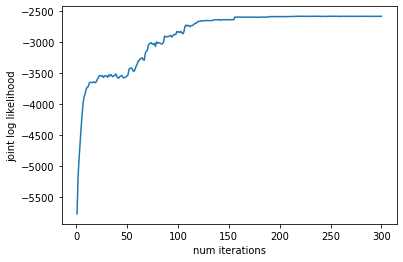

<Figure size 432x288 with 0 Axes>

In [9]:
x_axis = [i+1 for i in range(num_iters)]
plt.plot(x_axis, joint_lls)
plt.xlabel("num iterations")
plt.ylabel("joint log likelihood")
plt.show()

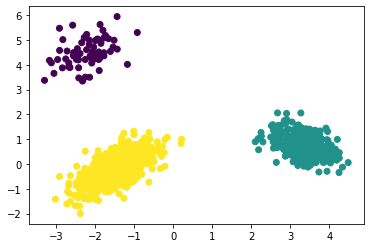

<Figure size 432x288 with 0 Axes>

In [8]:
plt.scatter(xs[:, 0].numpy(),
            xs[:, 1].numpy(), 
            c=zs.numpy())
plt.show()